# Group 3 Final Project Milestone Update

## Yelp recommedation system and sentiment analysis

In [1]:
import json,csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

import math
import time

import warnings
warnings.filterwarnings('ignore')

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, KFold

from sklearn.feature_extraction.text import TfidfTransformer,CountVectorizer,TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

from sklearn import metrics
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score

from surprise import Reader, Dataset, SVD,KNNWithMeans

In [2]:
import os     # operate system
os.getcwd()
os.chdir('/Users/weiweiwan/Desktop/DSC672/yelp-dataset') 

## Data Proprocessing

In [3]:
business = pd.read_csv('business.csv')
business.head(3)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,1SWheh84yJXfytovILXOAQ,Arizona Biltmore Golf Club,2818 E Camino Acequia Drive,Phoenix,AZ,85016,33.522143,-112.018481,3.0,5,0,{'GoodForKids': 'False'},"Golf, Active Life",NaN
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Mississauga,ON,L5R 3E7,43.605499,-79.652289,2.5,128,1,"{'RestaurantsReservations': 'True', 'GoodForMe...","Specialty Food, Restaurants, Dim Sum, Imported...","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W..."
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0,170,1,"{'GoodForKids': 'True', 'NoiseLevel': ""u'avera...","Sushi Bars, Restaurants, Japanese","{'Monday': '17:30-21:30', 'Wednesday': '17:30-..."


In [4]:
business.shape

(192609, 14)

### Fill missing value with empty string

In [5]:
#fill missing value with ''
print(business['categories'].isnull().sum())
business['categories'] = business['categories'].fillna('')
business['city'] = business['city'].fillna('')

482


### Explore popular business categories

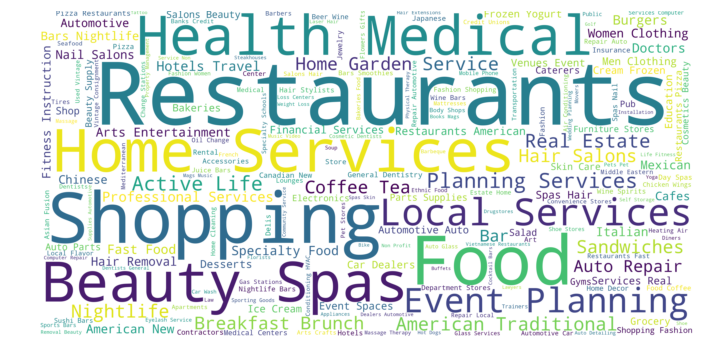

In [6]:
cat_list = ', '.join(business['categories'])
cat_list = pd.Series(cat_list.split(', '))

from wordcloud import WordCloud, STOPWORDS
cat_wordcloud = WordCloud(stopwords=STOPWORDS, height=2000, width=4000,
                            background_color='white').generate(','.join(cat_list.iloc[0:5000]))
# plot the category WordCloud 
plt.figure(figsize=(12,6)) 
plt.imshow(cat_wordcloud,interpolation="bilinear") 
plt.axis("off") 
plt.margins(x=0, y=0) 
plt.show() 

### Analyze all the restaurants in USA

In [7]:
## filter restaurants of US
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
usa=business.loc[business['state'].isin(states)]
usa.head(3)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,1SWheh84yJXfytovILXOAQ,Arizona Biltmore Golf Club,2818 E Camino Acequia Drive,Phoenix,AZ,85016,33.522143,-112.018481,3.0,5,0,{'GoodForKids': 'False'},"Golf, Active Life",NaN
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0,170,1,"{'GoodForKids': 'True', 'NoiseLevel': ""u'avera...","Sushi Bars, Restaurants, Japanese","{'Monday': '17:30-21:30', 'Wednesday': '17:30-..."
3,xvX2CttrVhyG2z1dFg_0xw,Farmers Insurance - Paul Lorenz,"15655 W Roosevelt St, Ste 237",Goodyear,AZ,85338,33.455613,-112.395596,5.0,3,1,NaN,"Insurance, Financial Services","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ..."


In [8]:
us_restaurants=usa[usa['categories'].str.contains('Restaurants')]
## select out 16 cuisine types of restaurants and rename the category
us_restaurants.is_copy=False
us_restaurants['category']=pd.Series()
us_restaurants.loc[us_restaurants.categories.str.contains('American'),'category'] = 'American'
us_restaurants.loc[us_restaurants.categories.str.contains('Mexican'), 'category'] = 'Mexican'
us_restaurants.loc[us_restaurants.categories.str.contains('Italian'), 'category'] = 'Italian'
us_restaurants.loc[us_restaurants.categories.str.contains('Japanese'), 'category'] = 'Japanese'
us_restaurants.loc[us_restaurants.categories.str.contains('Chinese'), 'category'] = 'Chinese'
us_restaurants.loc[us_restaurants.categories.str.contains('Thai'), 'category'] = 'Thai'
us_restaurants.loc[us_restaurants.categories.str.contains('Mediterranean'), 'category'] = 'Mediterranean'
us_restaurants.loc[us_restaurants.categories.str.contains('French'), 'category'] = 'French'
us_restaurants.loc[us_restaurants.categories.str.contains('Vietnamese'), 'category'] = 'Vietnamese'
us_restaurants.loc[us_restaurants.categories.str.contains('Greek'),'category'] = 'Greek'
us_restaurants.loc[us_restaurants.categories.str.contains('Indian'),'category'] = 'Indian'
us_restaurants.loc[us_restaurants.categories.str.contains('Korean'),'category'] = 'Korean'
us_restaurants.loc[us_restaurants.categories.str.contains('Hawaiian'),'category'] = 'Hawaiian'
us_restaurants.loc[us_restaurants.categories.str.contains('African'),'category'] = 'African'
us_restaurants.loc[us_restaurants.categories.str.contains('Spanish'),'category'] = 'Spanish'
us_restaurants.loc[us_restaurants.categories.str.contains('Middle_eastern'),'category'] = 'Middle_eastern'
us_restaurants.category[:10]

2     Japanese
11     Mexican
13     Italian
17     Italian
23         NaN
25     Mexican
35     Italian
58         NaN
66         NaN
73    Japanese
Name: category, dtype: object

#### The popular cusine type

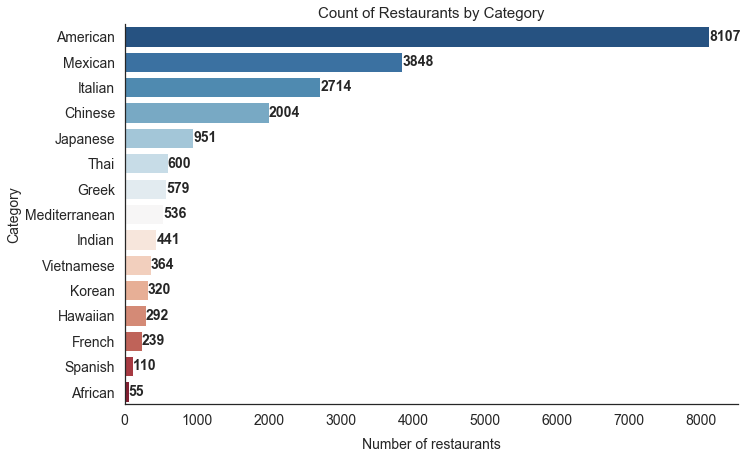

In [9]:
plt.figure(figsize=(11,7))
grouped = us_restaurants.category.value_counts()
sns.set(style="white")
sns.countplot(y='category',data=us_restaurants, 
              order = grouped.index, palette= sns.color_palette("RdBu_r", len(grouped)))
plt.xlabel('Number of restaurants', fontsize=14, labelpad=10)
plt.ylabel('Category', fontsize=14)
plt.title('Count of Restaurants by Category', fontsize=15)
plt.tick_params(labelsize=14)
for  i, v in enumerate(us_restaurants.category.value_counts()):
    plt.text(v, i+0.15, str(v), fontweight='bold', fontsize=14)
sns.despine()
plt.savefig("/Users/weiweiwan/Desktop/DSC672/finalSubmission/cat.png");

#### The distribution of restaurants by states

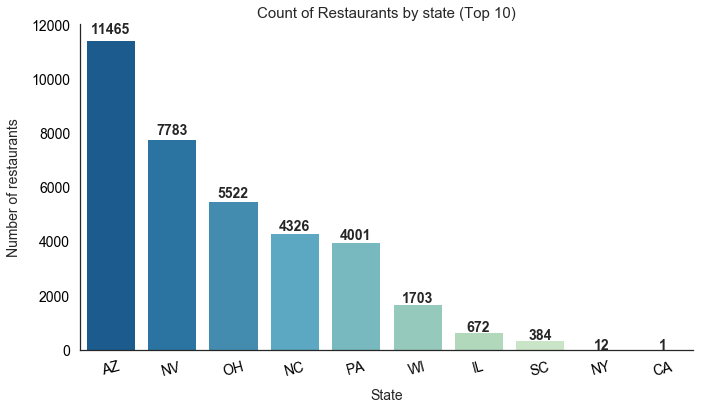

In [10]:
plt.figure(figsize=(11,6))
grouped = us_restaurants.state.value_counts()[:10]
sns.set(style="white")
sns.barplot(grouped.index, grouped.values, palette=sns.color_palette("GnBu_r", len(grouped)))
sns.despine()
plt.ylabel('Number of restaurants', fontsize=14, labelpad=10)
plt.xlabel('State', fontsize=14, labelpad=10)
plt.title('Count of Restaurants by state (Top 10)', fontsize=15)

plt.tick_params(colors='BLACK',labelsize=14)
plt.xticks(rotation=15)
for  i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)
plt.savefig("/Users/weiweiwan/Desktop/DSC672/finalSubmission/St0_1.png");

#### The distribution of restaurants by cities

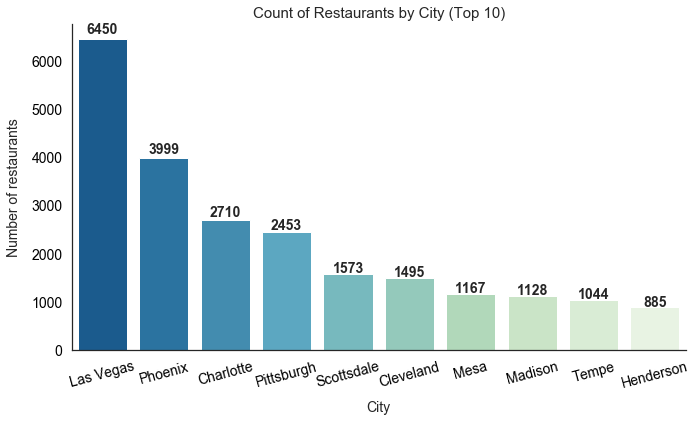

In [11]:
plt.figure(figsize=(11,6))
grouped = us_restaurants.city.value_counts()[:10]
sns.set(style="white")
sns.barplot(grouped.index, grouped.values, palette=sns.color_palette("GnBu_r", len(grouped)))
sns.despine()
plt.ylabel('Number of restaurants', fontsize=14, labelpad=10)
plt.xlabel('City', fontsize=14, labelpad=10)
plt.title('Count of Restaurants by City (Top 10)', fontsize=15)

plt.tick_params(colors='BLACK',labelsize=14)
plt.xticks(rotation=15)
for  i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)
plt.savefig("/Users/weiweiwan/Desktop/DSC672/finalSubmission/Ct0.png");

#### The distribution of restaurants by states

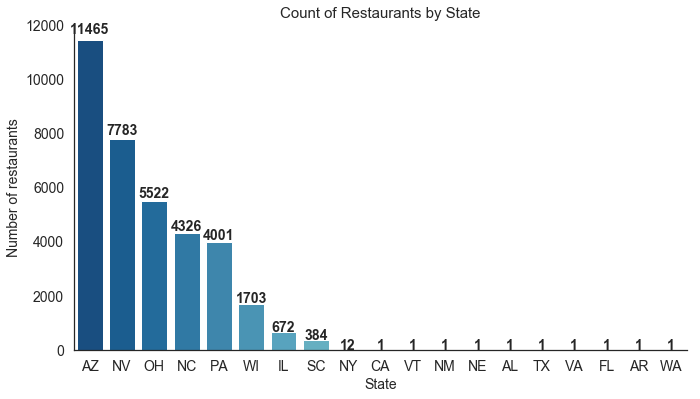

In [12]:
plt.figure(figsize=(11,6))
grouped = us_restaurants.state.value_counts()
sns.set(style="white")
sns.barplot(grouped.index, grouped.values,palette=sns.color_palette("GnBu_r", len(grouped)) )
sns.despine()
plt.ylabel('Number of restaurants', fontsize=14)
plt.xlabel('State', fontsize=14)
plt.title('Count of Restaurants by State', fontsize=15)
plt.tick_params(labelsize=14)
for  i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment ='center', fontweight='bold', fontsize=14)
plt.savefig("/Users/weiweiwan/Desktop/DSC672/finalSubmission/ST0.png");

#### The distribution of reviews by cities

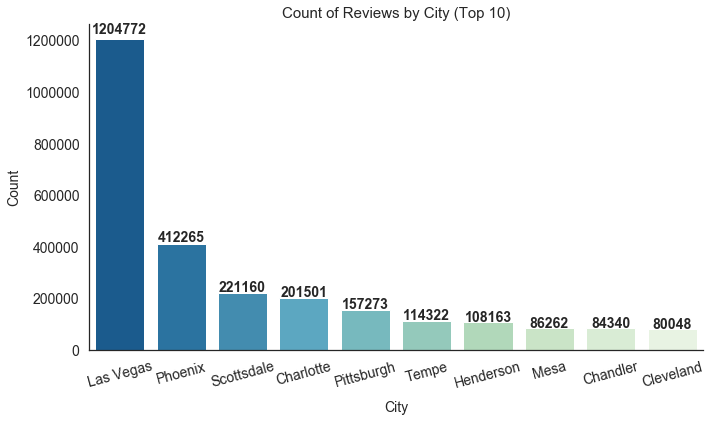

In [13]:
plt.figure(figsize=(11,6))
sns.set(style="white")
grouped = us_restaurants.groupby('city')['review_count'].sum().sort_values(ascending=False)[:10]
sns.barplot(grouped.index, grouped.values, palette=sns.color_palette("GnBu_r", len(grouped)) )
sns.despine()
plt.xlabel('City', labelpad=10, fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Count of Reviews by City (Top 10)', fontsize=15)
plt.tick_params(labelsize=14)
plt.xticks(rotation=15)
for  i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)

plt.savefig("/Users/weiweiwan/Desktop/DSC672/finalSubmission/Review0.png");

#### The distribution of star ratings

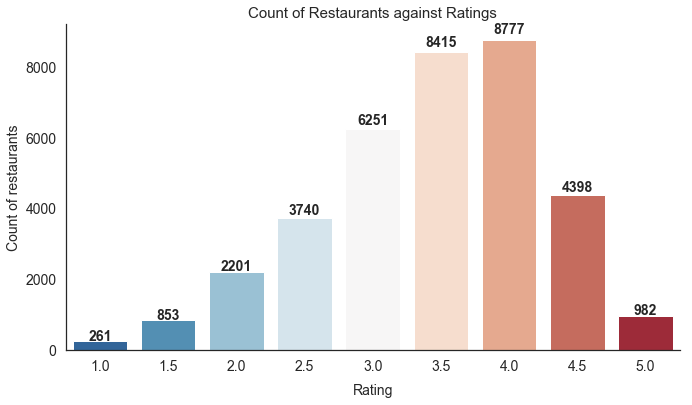

In [14]:
plt.figure(figsize=(11,6))
grouped = us_restaurants.stars.value_counts().sort_index()
sns.barplot(grouped.index, grouped.values, palette=sns.color_palette("RdBu_r", len(grouped)))
plt.xlabel('Rating', labelpad=10, fontsize=14)
plt.ylabel('Count of restaurants', fontsize=14)
plt.title('Count of Restaurants against Ratings', fontsize=15)
plt.tick_params(labelsize=14)
sns.despine()
for  i, v in enumerate(grouped):
    plt.text(i, v*1.02, str(v), horizontalalignment ='center',fontweight='bold', fontsize=14)
plt.savefig("/Users/weiweiwan/Desktop/DSC672/finalSubmission/sta8.png");

## Recommendation System

#### Based on above data exploratory analysis, the most popular business category is "restaurnats". The city Las Vegas has the highest number of restaurants and reviews. Therefore, in this project, we will first focus on the restaurants in Las Vegas.
#### We will build 4 recommendation systems:
* <b> Simple Recommendation </b>
* <b> Content filtering</b>
* <b> Collaborative filtering</b>
* <b> Hybrid filtering</b>

#### Based on above data exploratory analysis, the most popular business category is "restaurnats". The city Las Vegas has the highest number of restaurants and reviews. Therefore, in this project, we will first focus on the restaurants in Las Vegas.

In [15]:
SelectedCity = 'Las Vegas'
SelectedCategory = 'Restaurants'

CorrectCity = business['city'] == SelectedCity
CorrectCategory = business['categories'].apply(lambda x: x is not None and 'Restaurants' in x)
Filter = CorrectCity&CorrectCategory

restaurant_LSV  = business[Filter]
print(restaurant_LSV.shape)
restaurant_LSV.head(3)

(6450, 14)


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
17,PZ-LZzSlhSe9utkQYU8pFg,Carluccio's Tivoli Gardens,"1775 E Tropicana Ave, Ste 29",Las Vegas,NV,89119,36.100016,-115.128528,4.0,40,0,"{'OutdoorSeating': 'False', 'BusinessAcceptsCr...","Restaurants, Italian",NaN
25,tstimHoMcYbkSC4eBA1wEg,Maria's Mexican Restaurant & Bakery,6055 E Lake Mead Blvd,Las Vegas,NV,89156,36.195615,-115.040529,4.5,184,1,"{'BikeParking': 'True', 'BusinessParking': ""{'...","Mexican, Restaurants, Patisserie/Cake Shop, Fo...","{'Monday': '11:0-21:0', 'Tuesday': '10:0-21:0'..."
75,kANF0dbeoW34s2vwh6Umfw,Dairy Queen,6125 Spring Mountain Rd,Las Vegas,NV,89146,36.125031,-115.225620,2.0,33,0,"{'RestaurantsPriceRange2': '1', 'Ambience': ""{...","Fast Food, Food, Restaurants, Ice Cream & Froz...",NaN


### Simple Recommendation Engineer Based on User Input.

I use the star Ratings to come up with our **Top Restaurants Chart.** I will use IMDB's *weighted rating* formula (a common used formula in movie recommendation system) to construct my chart. Mathematically, it is represented as follows:

Weighted Rating (WR) = $(\frac{v}{v + m} . R) + (\frac{m}{v + m} . C)$

where,
* *v* is the number of votes for the restaurant
* *m* is the minimum votes required to be listed in the chart
* *R* is the average rating of the restaurant
* *C* is the mean vote across the whole report

The next step is to determine an appropriate value for *m*, the minimum votes required to be listed in the chart. We will use **60th percentile** as our cutoff. In other words, for a movie to feature in the charts, it must have more votes than at least 60% of the movies in the list.

I will build our overall Top 250 Chart and will define a function to build charts for a particular food category based on users' inputs.

In [16]:
#### SimpleRecommendation
#### recommend restaurants in Las Vegas with users define food type, and food rating.

def SimpleRecommendation(categoryList, percentile=0.6):
    categoryList = categoryList.strip().split(',')
    categoryList = [x.title() for x in categoryList] # capitalize the first letter
    df = restaurant_LSV[restaurant_LSV['categories'].apply(lambda x: all(word in x for word in categoryList))]
    if len(df)==0:
        print('Can not find {} in the categories. Please enter a new category.'.format(categoryList))
        return 
    else: 
        review_counts = df[df['review_count'].notnull()]['review_count'].astype('int')
        review_averages = df[df['stars'].notnull()]['stars'].astype('float')
        C = review_averages.mean()
        m = review_counts.quantile(percentile)

        qualified = df[(df['review_count'] >= m) & (df['review_count'].notnull()) & (df['stars'].notnull())][['name', 'address', 'stars', 'review_count','categories']]
        qualified['review_count'] = qualified['review_count'].astype('int')
        qualified['stars'] = qualified['stars'].astype('float')

        qualified['weighted_rating'] = qualified.apply(lambda x: (x['review_count']/(x['review_count']+m) * x['stars']) + (m/(m+x['review_count']) * C), axis=1)
        qualified = qualified.sort_values('weighted_rating', ascending=False).head(250)
    
        return qualified

#### Top 10 American Restaurants in Las Vegas

In [17]:
SimpleRecommendation('American, seafood').head(6)

,name,address,stars,review_count,categories,weighted_rating
55675,Carson Kitchen,"124 S 6th St, Ste 100",4.5,2024,"Bars, Restaurants, Nightlife, Cocktail Bars, A...",4.382752
138088,Mastro's Ocean Club,3720 S Las Vegas Blvd,4.5,1406,"Steakhouses, Restaurants, American (Traditiona...",4.341046
118737,Casa Di Amore,2850 E Tropicana Ave,4.5,837,"Italian, Seafood, Restaurants, American (New),...",4.263637
109033,The Capital Grille,3200 Las Vegas Blvd S,4.5,727,"American (New), Nightlife, American (Tradition...",4.239072
28776,Vic & Anthony's Steakhouse,129 E Fremont St,4.5,692,"Restaurants, Steakhouses, Seafood, American (N...",4.230148
178634,Pier 215,"7060 S Durango Dr, Ste 101",4.5,601,"Asian Fusion, American (Traditional), American...",4.203811


In [18]:
## captial insensitive
SimpleRecommendation('chinese,tea')

,name,address,stars,review_count,categories,weighted_rating
65799,Boba Hut,"5597 S Rainbow Blvd, Ste 130",4.0,312,"Asian Fusion, Chinese, Bubble Tea, Hawaiian, R...",3.898119
43237,J-Wok Cafe,5075 S Pecos Rd,4.0,65,"Food, Chinese, Bubble Tea, Restaurants, Juice ...",3.704545
24183,Fat Dumpling,3959 W Spring Mountain Rd,3.5,249,"Chinese, Food, Bubble Tea, Restaurants",3.481181
97199,Chun Fai Chinese Eatery,"6565 S Fort Apache Rd, Ste 175",3.5,213,"Restaurants, Chinese, Bubble Tea, Food, Thai, ...",3.478744
32956,Tea Station,"4355 Spring Mountain Rd, Ste 106",3.0,745,"Chinese, Restaurants, Taiwanese, Juice Bars & ...",3.032828
30345,Banana Leaf Café,2901 S Las Vegas Blvd,2.5,65,"Food, Asian Fusion, Coffee & Tea, Restaurants,...",2.954545


#### Besides the restaurant type and rating, users also concern price. The price information need to be extracted from "attributes"

In [19]:
restaurant_LSV['attributes'] = restaurant_LSV['attributes'].fillna('[]').apply(lambda x: eval(x))
restaurant_LSV['PriceRange'] = restaurant_LSV['attributes'].apply(lambda x: x['RestaurantsPriceRange2'] 
                                                if len(x)>0 and'RestaurantsPriceRange2' in x.keys() else 'None')
restaurant_LSV['PriceRange'] = restaurant_LSV['PriceRange'].apply(lambda x: eval(x))
print(restaurant_LSV['PriceRange'].value_counts())
restaurant_LSV.head(2)

2.0    2895
1.0    2656
3.0     299
4.0     116
Name: PriceRange, dtype: int64


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,PriceRange
17,PZ-LZzSlhSe9utkQYU8pFg,Carluccio's Tivoli Gardens,"1775 E Tropicana Ave, Ste 29",Las Vegas,NV,89119,36.100016,-115.128528,4.0,40,0,"{'OutdoorSeating': 'False', 'BusinessAcceptsCr...","Restaurants, Italian",NaN,2.0
25,tstimHoMcYbkSC4eBA1wEg,Maria's Mexican Restaurant & Bakery,6055 E Lake Mead Blvd,Las Vegas,NV,89156,36.195615,-115.040529,4.5,184,1,"{'BikeParking': 'True', 'BusinessParking': '{'...","Mexican, Restaurants, Patisserie/Cake Shop, Fo...","{'Monday': '11:0-21:0', 'Tuesday': '10:0-21:0'...",1.0


(array([   0.,  500., 1000., 1500., 2000., 2500., 3000., 3500.]),
 <a list of 8 Text yticklabel objects>)

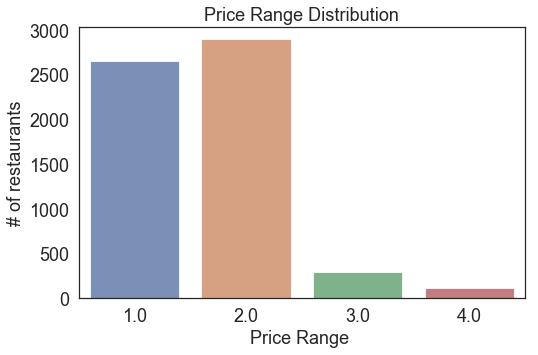

In [20]:
x=restaurant_LSV['PriceRange'].value_counts()
plt.figure(figsize=(8,5))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Price Range Distribution",fontsize=18)
plt.ylabel('# of restaurants', fontsize=18)
plt.xlabel('Price Range ', fontsize=18)
plt.xticks(rotation=0, fontsize=18)
plt.yticks(rotation=0, fontsize=18)

In [21]:
### recommend restaurants in Las Vegas 
### recommend by user define food type, food price, and food rating

def SimpleRecommendation1(categoryList,priceRange=4,percentile=0.6):
    
    df = restaurant_LSV[restaurant_LSV['PriceRange']<=priceRange]
    categoryList = categoryList.strip().split(',')
    categoryList = [x.title() for x in categoryList] # capitalize the first letter
    
    df = df[df['categories'].apply(lambda x: all(word in x for word in categoryList))]
    
    if len(df)==0:
        print('Can not find {} in the categories. Please enter a new category.'.format(categoryList))
        return 
    else: 
        review_counts = df[df['review_count'].notnull()]['review_count'].astype('int')
        review_averages = df[df['stars'].notnull()]['stars'].astype('float')
        C = review_averages.mean()
        m = review_counts.quantile(percentile)

        qualified = df[(df['review_count'] >= m) & (df['review_count'].notnull()) & (df['stars'].notnull())][['name', 'address', 'stars', 'review_count','categories','PriceRange']]
                                                                                                        
        qualified['review_count'] = qualified['review_count'].astype('int')
        qualified['stars'] = qualified['stars'].astype('float')

        qualified['weighted_rating'] = qualified.apply(lambda x: (x['review_count']/(x['review_count']+m) * x['stars']) + (m/(m+x['review_count']) * C), axis=1)
        qualified = qualified.sort_values('weighted_rating', ascending=False).head(250)
        
        print("Recommend {} restaurants with price <= {} and review_count >= {}".format(categoryList,priceRange,int(m)))
    
        return qualified

In [22]:
SimpleRecommendation1('american,seafood',2,0.7).head(10)

Recommend ['American', 'Seafood'] restaurants with price <= 2 and review_count >= 361


,name,address,stars,review_count,categories,PriceRange,weighted_rating
55675,Carson Kitchen,"124 S 6th St, Ste 100",4.5,2024,"Bars, Restaurants, Nightlife, Cocktail Bars, A...",2.0,4.355395
118737,Casa Di Amore,2850 E Tropicana Ave,4.5,837,"Italian, Seafood, Restaurants, American (New),...",2.0,4.212130
178634,Pier 215,"7060 S Durango Dr, Ste 101",4.5,601,"Asian Fusion, American (Traditional), American...",2.0,4.141517
13405,Urban Crawfish Station,"4821 Spring Mountain Rd, Ste C",4.5,578,"Cajun/Creole, Vietnamese, Seafood, American (T...",2.0,4.132737
68604,Hot N Juicy Crawfish,"4810 Spring Mountain Rd, Ste C & D",4.0,1706,"Cajun/Creole, Restaurants, American (Tradition...",2.0,3.920494
170476,Momofuku Las Vegas,"3708 Las Vegas Blvd S, Level 2",4.0,1575,"Seafood, Restaurants, American (New), Noodles,...",2.0,3.915115
41603,Yard House,6593 Las Vegas Blvd S,4.0,1375,"Steakhouses, American (Traditional), Restauran...",2.0,3.905336
191152,Grand Lux Cafe,"3327 Las Vegas Blvd S, Ste 1580",4.0,1193,"Restaurants, American (New), Food, American (T...",2.0,3.894250
186688,Triple George Grill,"201 N 3rd St, Ste 120",4.0,1064,"American (New), Steakhouses, Seafood, Restaurants",2.0,3.884677
163462,Yard House,3545 Las Vegas Blvd,4.0,1015,"American (Traditional), Restaurants, American ...",2.0,3.880571


### Recommend: including city selection and selected category

In [23]:
def SimpleRecommendation2(SelectedCity,SelectedCategory,categoryList,priceRange=4,percentile=0.6):
    #SelectedCity = 'Las Vegas'
    # filter the city
    
    citylist = set(business['city'])
    catlist = ', '.join(business['categories']).split(', ')
    
    SelectedCity = SelectedCity.strip().title()
    SelectedCategory = SelectedCategory.title()
    
    if SelectedCity not in citylist:
        print('Can not find city {}. Please enter a new city.'.format(SelectedCity))
        return 
    
    if SelectedCategory not in catlist:
        print('Can not find category:{}. Please update a new category.'.format(SelectedCategory))
        return 
    
    CorrectCity = business['city'] == SelectedCity
    CorrectCategory = business['categories'].apply(lambda x: x is not None and SelectedCategory in x)
    Filter = CorrectCity&CorrectCategory

    df = business[Filter]
    
    ## get the price range
    
    df['attributes'] = df['attributes'].fillna('[]').apply(lambda x: eval(x))

    df['PriceRange'] = df['attributes'].apply(lambda x: x['RestaurantsPriceRange2'] 
                                                if len(x)>0 and'RestaurantsPriceRange2' in x.keys() else '0')
    df['PriceRange'] = df['PriceRange'].apply(lambda x: eval(x))

    
    df = df[df['PriceRange']<=priceRange]
    
    ## get the category_List separated by ","
    categoryList = categoryList.strip().split(',')
    categoryList = [x.title() for x in categoryList] # title all the letters
    
    df = df[df['categories'].apply(lambda x: all(word in x for word in categoryList))]
    
    if len(df)==0:
        print('Can not find {} in the categories. Please enter a new category.'.format(categoryList))
        return 
    else: 
        review_counts = df[df['review_count'].notnull()]['review_count'].astype('int')
        review_averages = df[df['stars'].notnull()]['stars'].astype('float')
        C = review_averages.mean()
        m = review_counts.quantile(percentile)

        qualified = df[(df['review_count'] >= m) & (df['review_count'].notnull()) & (df['stars'].notnull())][['name', 'address','city','stars', 'review_count','categories','PriceRange']]
                                                                                                        
        qualified['review_count'] = qualified['review_count'].astype('int')
        qualified['stars'] = qualified['stars'].astype('float')

        qualified['weighted_rating'] = qualified.apply(lambda x: (x['review_count']/(x['review_count']+m) * x['stars']) + (m/(m+x['review_count']) * C), axis=1)
        qualified = qualified.sort_values('weighted_rating', ascending=False).head(250)
        
        print("Recommend {} restaurants in city {} with price <= {} and review_count >= {}".format(categoryList,SelectedCity,priceRange,int(m)))
    
        return qualified

#### Recommend Beauty & Spas in the city of Toronto

In [24]:
SimpleRecommendation2('Toronto','Beauty & Spas','Barbers',1,0.7).head(5)

Recommend ['Barbers'] restaurants in city Toronto with price <= 1 and review_count >= 8


,name,address,city,stars,review_count,categories,PriceRange,weighted_rating
65747,Uptown Barber Shop,4 Isabella Street,Toronto,5.0,41,"Beauty & Spas, Hair Salons, Barbers",1.0,4.861742
130655,Tom's Barber Shop,823 Runnymede Road,Toronto,5.0,26,"Beauty & Spas, Barbers, Hair Salons",1.0,4.801103
185424,George's Barber Shop,182 Royal York Road,Toronto,5.0,15,"Barbers, Beauty & Spas",1.0,4.706799
36697,Mr. Nonno Barber Shop,609 Bloor Street W,Toronto,5.0,12,"Barbers, Beauty & Spas",1.0,4.663254
3450,Anna's Barber Shop,7 Erskine Avenue,Toronto,4.5,15,"Barbers, Beauty & Spas",1.0,4.383523


## Content Based Recommender

#### The Content Based Recommender recommends restaurants based on the restaurants similarity

#### Cosine Similarity

I will be using the Cosine Similarity to calculate a numeric quantity that denotes the similarity between two restaurants. Mathematically, it is defined as follows:

$cosine(x,y) = \frac{x. y^\intercal}{||x||.||y||} $

Since we have used the TF-IDF Vectorizer, calculating the Dot Product will directly give us the Cosine Similarity Score. Therefore, we will use sklearn's **linear_kernel** instead of cosine_similarities since it is much faster.

In [25]:
tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 2),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(restaurant_LSV['categories'])

In [26]:
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
cosine_sim[0]
print(cosine_sim.shape)

(6450, 6450)


In [27]:
smd = restaurant_LSV.copy()
smd = smd.reset_index()
indices = pd.Series(smd.index, index=smd['name'])
print(indices.head(5))

name
Carluccio's Tivoli Gardens             0
Maria's Mexican Restaurant & Bakery    1
Dairy Queen                            2
Imperial Asian Buffet                  3
Artisan Fine Dining Room               4
dtype: int64


In [28]:
def get_recommendations(name):
    idx = indices[name]
    if isinstance(idx, pd.Series):
        idx =idx.iloc[0]
    
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    item_indices = [i[0] for i in sim_scores]
    
    return smd.iloc[item_indices][['name', 'address','stars','review_count']]

In [29]:
get_recommendations("Dairy Queen").head(7)

,name,address,stars,review_count
6253,Dairy Queen,7400 Las Vegas Blvd S,3.5,6
4284,Dairy Queen,3850 S Las Vegas Blvd,2.5,13
5893,Ben & Jerry's Ice Cream,3790 Las Vegas Blvd S,3.5,11
1899,Aromi d' Italia,"Miracle Mile Shops, 3663 S Las Vegas Blvd S, S...",2.5,28
5355,Dairy Queen,560 E Windmill Ln,2.5,22
313,Sonic Drive-In,2301 E Sahara Ave,2.5,29
716,Create,"7290 W Lake Mead Blvd, Ste 2",4.0,137


In [30]:
get_recommendations("Carluccio's Tivoli Gardens").head(7)

,name,address,stars,review_count
74,Market City Caffe,3770 Las Vegas Blvd S,3.5,11
568,Il Mulino New York,"3500 Las Vegas Blvd S, Ste T30",4.0,305
813,Pasquales Ristorante,8615 W Sahara Ave,4.5,8
1038,Fazoli's,1260 N Town Center Dr,3.5,50
1039,Circo,"Bellagio Las Vegas, 3600 S Las Vegas Blvd",4.0,200
1123,Casa Nicola,3000 Paradise Rd,2.5,7
1481,Fazoli's 5268,5260 S Fort Apache Rd,3.0,12


#### Similarity combines Weighted Ratings

One thing that we notice about our recommendation system is that it recommends restaurants regardless of ratings and popularity. One restaurant which is quite similar to the target one may have very low weighted-rating score. In this case, we won't recommend the low-rating restaurant although it has high similarity. 

Therefore, we will add a mechanism to remove low-rating restaurants and return restaurants which are popular and have had a good critical response.

I will take the top 30 restaurnts based on similarity scores and calculate the vote of the 60th percentile restaurant. Then, we will calculate the weighted rating of each restaurant using the formula like we did in the Simple Recommender section.

In [31]:
def improved_recommendations(name,percentile=0.6):
    idx = indices[name]
    if isinstance(idx, pd.Series):
        idx =idx.iloc[0]
    
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    item_indices = [i[0] for i in sim_scores]
    
    df = smd.iloc[item_indices][['name', 'address', 'stars','review_count']]
    review_counts = df[df['review_count'].notnull()]['review_count'].astype('int')
    review_averages = df[df['stars'].notnull()]['stars'].astype('float')
    C = review_averages.mean()
    m = review_counts.quantile(percentile)

    qualified = df[(df['review_count'] >= m) & (df['review_count'].notnull()) & (df['stars'].notnull())]
    qualified['review_count'] = qualified['review_count'].astype('int')
    qualified['stars'] = qualified['stars'].astype('float')

    qualified['weighted_rating'] = qualified.apply(lambda x: (x['review_count']/(x['review_count']+m) * x['stars']) + (m/(m+x['review_count']) * C), axis=1)
    qualified = qualified.sort_values('weighted_rating', ascending=False).head(15)
    return qualified

In [32]:
improved_recommendations("Dairy Queen").head(7)

,name,address,stars,review_count,weighted_rating
1686,Freddy's Frozen Custard & Steakburgers,9809 S Eastern Ave,4.0,384,3.889801
180,Menchie's Frozen Yogurt,"5651 S Grand Canyon Dr, Ste 140",4.5,59,3.835456
2515,Lappert's Ice Cream Shop,12 Ogden Ave,4.0,220,3.824603
4104,Shake Shack,3780 S Las Vegas Blvd,4.0,165,3.781188
716,Create,"7290 W Lake Mead Blvd, Ste 2",4.0,137,3.749640
2128,Shake Shack,10975 Oval Park Dr,3.5,547,3.466865
6178,Pizza Place,3131 Las Vegas Blvd. South,3.5,88,3.362121


## Collaborative Filtering

Our content based engine suffers from some severe limitations. The engine that we built is not really personal in that it doesn't capture the personal tastes and biases of a user. Anyone querying our engine for recommendations based on a restaurant will receive the same recommendations for that restaurant, regardless of who s/he is.

Therefore, in this section, we will use a technique called Collaborative Filtering to make recommendations to yelp users. Collaborative Filtering is based on the idea that users similar to me can be used to predict how much I will like a particular restaurants or service those users have used/experienced but I have not.

Now let’s look at the different types of algorithms in the family of collaborative filtering.

* <b>Memory Based</b>

The first category includes algorithms that are memory based, in which statistical techniques are applied to the entire dataset to calculate the predictions.

To find the rating R that a user U would give to an item I, the approach includes:

>- <b>User-based</b>:
Finding users similar to U who have rated the item I
Calculating the rating R based the ratings of users found in the previous step

>- <b>Item-based</b>: 
Finding items similar to I which have been rated by User U
Calculating the rating R based the ratings of items found in the previous step


* <b>Model Based</b>

The second category covers the Model based approaches, which involve a step to reduce or compress the large but sparse user-item matrix.

Matrix factorization: decomposing the user-item interaction matrix into the product of two lower dimensionality matrices: User Matrix, and Item Matrix.

One of the popular algorithms to factorize a matrix is the singular value decomposition (SVD) algorithm. SVD came into the limelight when matrix factorization was seen performing well in the Netflix prize competition. Other algorithms include PCA and its variations, NMF, and so on. Autoencoders can also be used for dimensionality reduction in case you want to use Neural Networks.


In [89]:
## read review
review = pd.read_csv('review.csv')
review.shape
review.head(5)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,Q1sbwvVQXV2734tPgoKj4Q,hG7b0MtEbXx5QzbzE6C_VA,ujmEBvifdJM6h6RLv4wQIg,1.0,6,1,0,Total bill for this horrible service? Over $8G...,2013-05-07 04:34:36
1,GJXCdrto3ASJOqKeVWPi6Q,yXQM5uF2jS6es16SJzNHfg,NZnhc2sEQy3RmzKTZnqtwQ,5.0,0,0,0,I *adore* Travis at the Hard Rock's new Kelly ...,2017-01-14 21:30:33
2,2TzJjDVDEuAW6MR5Vuc1ug,n6-Gk65cPZL6Uz8qRm3NYw,WTqjgwHlXbSFevF32_DJVw,5.0,3,0,0,I have to say that this office really has it t...,2016-11-09 20:09:03
3,yi0R0Ugj_xUx_Nek0-_Qig,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5.0,0,0,0,Went in for a lunch. Steak sandwich was delici...,2018-01-09 20:56:38
4,11a8sVPMUFtaC7_ABRkmtw,ssoyf2_x0EQMed6fgHeMyQ,b1b1eb3uo-w561D0ZfCEiQ,1.0,7,0,0,Today was my second out of three sessions I ha...,2018-01-30 23:07:38


In [41]:
review_sub = review[['review_id','user_id','business_id','stars']]
print(review_sub.shape)

(6685900, 4)


In [42]:
review_sub.head()

,review_id,user_id,business_id,stars
0,Q1sbwvVQXV2734tPgoKj4Q,hG7b0MtEbXx5QzbzE6C_VA,ujmEBvifdJM6h6RLv4wQIg,1.0
1,GJXCdrto3ASJOqKeVWPi6Q,yXQM5uF2jS6es16SJzNHfg,NZnhc2sEQy3RmzKTZnqtwQ,5.0
2,2TzJjDVDEuAW6MR5Vuc1ug,n6-Gk65cPZL6Uz8qRm3NYw,WTqjgwHlXbSFevF32_DJVw,5.0
3,yi0R0Ugj_xUx_Nek0-_Qig,dacAIZ6fTM6mqwW5uxkskg,ikCg8xy5JIg_NGPx-MSIDA,5.0
4,11a8sVPMUFtaC7_ABRkmtw,ssoyf2_x0EQMed6fgHeMyQ,b1b1eb3uo-w561D0ZfCEiQ,1.0


In [43]:
restaurant_LSV.head(1)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,PriceRange
17,PZ-LZzSlhSe9utkQYU8pFg,Carluccio's Tivoli Gardens,"1775 E Tropicana Ave, Ste 29",Las Vegas,NV,89119,36.100016,-115.128528,4.0,40,0,"{'OutdoorSeating': 'False', 'BusinessAcceptsCr...","Restaurants, Italian",NaN,2.0


In [44]:
# join datasets
Review_LSVRestaurants = pd.merge(restaurant_LSV[['business_id','city']], review_sub, on='business_id', how = 'inner')

In [45]:
print(Review_LSVRestaurants.shape)
Review_LSVRestaurants.head()

(1242711, 5)


,business_id,city,review_id,user_id,stars
0,PZ-LZzSlhSe9utkQYU8pFg,Las Vegas,klcF45wKIOpJW_BhJslOJg,-Yz2wIcsdJxUOFMbTgoKQA,5.0
1,PZ-LZzSlhSe9utkQYU8pFg,Las Vegas,Li-pQG6A7p5gbgZHTMeDSQ,jYcf_e5p0UG0S-9gJq_tNA,4.0
2,PZ-LZzSlhSe9utkQYU8pFg,Las Vegas,iRLX3dJ3ONvncIxPnXy1cw,nQC0JiPIk_jCooRDxpuw5A,5.0
3,PZ-LZzSlhSe9utkQYU8pFg,Las Vegas,rklteWf9xnTU3fAtMFBRRw,Gv_-mtOKhWFtCjn9xFe0SQ,3.0
4,PZ-LZzSlhSe9utkQYU8pFg,Las Vegas,UfRqM0RGdZa86hFcFEAnjw,pabMYegF28KjHQ5hybAJ0A,3.0


In [46]:
review_sub2 = Review_LSVRestaurants[['review_id','user_id','business_id','stars']]

#### label encode user_id and business_id

In [47]:
label_encoder = preprocessing.LabelEncoder() 
label_encoder.fit(review_sub2['user_id']) 
review_sub2['user_id']= label_encoder.transform(review_sub2['user_id']) 

label_encoder1 = preprocessing.LabelEncoder() 
label_encoder1.fit(smd['business_id']) 
review_sub2['business_id']= label_encoder1.transform(review_sub2['business_id']) 

review_sub2 = review_sub2.sort_values(by = ["user_id","business_id"], ascending = True)
review_sub3 = review_sub2[['user_id','business_id','stars']]
review_sub3.reset_index(drop=True,inplace=True)
review_sub3.shape

(1242711, 3)

In [48]:
#review_sub4 = review_sub3.head(40026)
review_sub4 = review_sub3
review_sub4.head(10)

,user_id,business_id,stars
0,0,0,4.0
1,0,238,1.0
2,0,310,1.0
3,0,642,5.0
4,0,643,4.0
5,0,643,1.0
6,0,794,1.0
7,0,855,1.0
8,0,1074,5.0
9,0,1137,5.0


In [49]:
review_sub4.tail()

,user_id,business_id,stars
1242706,439158,2193,3.0
1242707,439159,3106,3.0
1242708,439160,3050,5.0
1242709,439161,1741,1.0
1242710,439162,787,5.0


In [50]:
1242711/439162

2.829732536057309

Since there are total 1242711 reviews from 439162 users on 6450 businesses. By average, each users has 3 reviews. The review matrix is very sparse. We will not be implementing Collaborative Filtering by memory based approach. Instead, we will use the Surprise library that used extremely powerful algorithms like Singular Value Decomposition (SVD) to minimise RMSE (Root Mean Square Error) and give great recommendations.

In [51]:
#from surprise import Reader, Dataset, SVD,KNNWithMeans
#from surprise.model_selection import cross_validate,GridSearchCV, KFold
reader = Reader()
data = Dataset.load_from_df(review_sub4[['user_id', 'business_id', 'stars']], reader)

In [52]:
#from surprise.model_selection import cross_validate,GridSearchCV, KFold
from surprise import model_selection
svd = SVD()
# Run 5-fold cross-validation and then print results
model_selection.cross_validate(svd, data, measures=['RMSE', 'MAE'],cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2605  1.2610  1.2636  1.2629  1.2600  1.2616  0.0014  
MAE (testset)     1.0105  1.0112  1.0127  1.0121  1.0097  1.0112  0.0011  
Fit time          59.41   58.99   59.20   60.85   60.27   59.74   0.71    
Test time         2.43    2.41    2.42    2.45    1.90    2.32    0.21    


{'test_rmse': array([1.26053212, 1.26101018, 1.26357255, 1.26294323, 1.26002245]),
 'test_mae': array([1.01045797, 1.01121723, 1.01265127, 1.01210522, 1.0096555 ]),
 'fit_time': (59.41377401351929,
  58.987823247909546,
  59.195565938949585,
  60.8534038066864,
  60.26695895195007),
 'test_time': (2.4342238903045654,
  2.4127838611602783,
  2.417943000793457,
  2.4509902000427246,
  1.900806188583374)}

In [53]:
trainset = data.build_full_trainset()
svd.fit(trainset)

In [54]:
#predict user 0 on restaurant 100
svd.predict(0, 100)

Prediction(uid=0, iid=100, r_ui=None, est=3.067710592262629, details={'was_impossible': False})

In [55]:
#predict user 0 on restaurant 500
svd.predict(0, 500)

Prediction(uid=0, iid=500, r_ui=None, est=3.34308202417443, details={'was_impossible': False})

## Hybrid Recommender

In this section, I will try to build a simple hybrid recommender that brings together techniques we have implemented in the content based and collaborative filter based engines. This is how it will work:

* **Input:** User ID and the name of a restaurant
* **Output:** Similar restaurant sorted on the basis of expected ratings by that particular user.

In [56]:
def convert_int(x):
    try:
        return int(x)
    except:
        return np.nan

In [57]:
smd2 = smd.copy()
smd2['business_index'] = smd2.index
smd2['business_id']= label_encoder1.transform(smd2['business_id']) 
smd2.tail(3)

,index,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,PriceRange,business_index
6447,192507,429,Marco's Pizza,7540 Oso Blanca Rd,Las Vegas,NV,89149,36.296746,-115.288481,3.5,24,1,"{'RestaurantsTakeOut': 'True', 'RestaurantsDel...","Restaurants, Pizza","{'Monday': '10:0-23:0', 'Tuesday': '10:0-23:0'...",NaN,6447
6448,192517,4117,Great Steak & Potato,755 S Grand Central Pkwy,Las Vegas,NV,89106,36.164316,-115.157446,2.0,5,0,"{'NoiseLevel': 'u'loud'', 'Caters': 'False', '...","Restaurants, Fast Food",NaN,1.0,6448
6449,192562,5245,Jessie Rae's BBQ,5611 S Valley View Blvd,Las Vegas,NV,89118,36.087895,-115.190329,4.5,595,1,"{'Caters': 'True', 'RestaurantsTableService': ...","Farmers Market, Caterers, Food, Street Vendors...","{'Monday': '0:0-0:0', 'Tuesday': '11:30-20:30'...",2.0,6449


In [58]:
id_map = smd2[['name','business_id','business_index']]
id_map = id_map.set_index('name')
id_map.head()

,business_id,business_index
name,,
Carluccio's Tivoli Gardens,2660,0
Maria's Mexican Restaurant & Bakery,5831,1
Dairy Queen,4864,2
Imperial Asian Buffet,3476,3
Artisan Fine Dining Room,3978,4


In [59]:
indices = pd.Series(id_map['business_index'],index=id_map.index)
indices

name
Carluccio's Tivoli Gardens                     0
Maria's Mexican Restaurant & Bakery            1
Dairy Queen                                    2
Imperial Asian Buffet                          3
Artisan Fine Dining Room                       4
Bistro Divino                                  5
La Creperie                                    6
Feast Buffet                                   7
Vince Neil's Tatuado | Eat, Drink, Party       8
Stage Deli Of Las Vegas                        9
Pita Pit                                      10
Mr G's Pub & Grub                             11
Bonjour Bakery & Deli                         12
Body Food Kitchen                             13
Coffee, Tea, or Me                            14
TJ's Steakhouse                               15
Empress Court                                 16
Albinas Italian American Bakery               17
Metro Pizza                                   18
Chipotle Mexican Grill                        19
Paradise Boba T

In [60]:
name = "Carluccio's Tivoli Gardens"
idx = indices[name]
idx

0

In [61]:
id_map.head(2)

,business_id,business_index
name,,
Carluccio's Tivoli Gardens,2660,0
Maria's Mexican Restaurant & Bakery,5831,1


In [62]:
id_map.loc[name]['business_id']

2660

In [63]:
def hybrid(userId, name):
    idx = indices[name]
    if isinstance(idx, pd.Series):
        idx =idx.iloc[0]
        
    business_id = id_map.loc[name]['business_id']
    
    sim_scores = list(enumerate(cosine_sim[int(idx)]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:31]
    item_indices = [i[0] for i in sim_scores]
    
    businesses = smd2.iloc[item_indices][['name', 'address','business_id']]
    businesses['est'] = businesses['business_id'].apply(lambda x: svd.predict(userId, x).est)
    businesses = businesses.sort_values('est', ascending=False)
    return businesses.head(10)

### Recommend restaurants similar to "Dairy Queen" are different to different users

In [64]:
hybrid(1, "Dairy Queen")

,name,address,business_id,est
2515,Lappert's Ice Cream Shop,12 Ogden Ave,4323,4.488358
4261,La Flor Es Michoacan,4161 S Eastern Ave,5849,4.350660
5029,Hawaiian Frost LV,8095 S Rainbow Blvd,4474,4.146954
1686,Freddy's Frozen Custard & Steakburgers,9809 S Eastern Ave,4638,4.124225
180,Menchie's Frozen Yogurt,"5651 S Grand Canyon Dr, Ste 140",1091,4.121151
4104,Shake Shack,3780 S Las Vegas Blvd,2250,4.025186
5437,Ghirardelli Ice Cream and Chocolate Shop,"Harrah's Carnaval Court, 3475 Las Vegas Blvd S",3792,3.974168
6253,Dairy Queen,7400 Las Vegas Blvd S,4154,3.971016
3974,Froyo Time,"3310 E Flamingo Rd, Ste 3A",3871,3.950555
716,Create,"7290 W Lake Mead Blvd, Ste 2",3300,3.773665


In [65]:
hybrid(2, "Dairy Queen")

,name,address,business_id,est
1686,Freddy's Frozen Custard & Steakburgers,9809 S Eastern Ave,4638,4.228008
180,Menchie's Frozen Yogurt,"5651 S Grand Canyon Dr, Ste 140",1091,4.216837
5437,Ghirardelli Ice Cream and Chocolate Shop,"Harrah's Carnaval Court, 3475 Las Vegas Blvd S",3792,4.142983
4104,Shake Shack,3780 S Las Vegas Blvd,2250,4.105712
5029,Hawaiian Frost LV,8095 S Rainbow Blvd,4474,4.085391
716,Create,"7290 W Lake Mead Blvd, Ste 2",3300,4.078127
4261,La Flor Es Michoacan,4161 S Eastern Ave,5849,3.938939
2515,Lappert's Ice Cream Shop,12 Ogden Ave,4323,3.923926
3899,Sweet Chill,"Aria Resort and Casino, 3741 Las Vegas Blvd S",3089,3.873037
6253,Dairy Queen,7400 Las Vegas Blvd S,4154,3.848339


In [66]:
hybrid(3, "Dairy Queen")

,name,address,business_id,est
180,Menchie's Frozen Yogurt,"5651 S Grand Canyon Dr, Ste 140",1091,4.365406
5437,Ghirardelli Ice Cream and Chocolate Shop,"Harrah's Carnaval Court, 3475 Las Vegas Blvd S",3792,4.219377
4104,Shake Shack,3780 S Las Vegas Blvd,2250,4.206581
1686,Freddy's Frozen Custard & Steakburgers,9809 S Eastern Ave,4638,4.186903
716,Create,"7290 W Lake Mead Blvd, Ste 2",3300,4.074383
4261,La Flor Es Michoacan,4161 S Eastern Ave,5849,4.070841
5029,Hawaiian Frost LV,8095 S Rainbow Blvd,4474,3.900772
3974,Froyo Time,"3310 E Flamingo Rd, Ste 3A",3871,3.896595
6253,Dairy Queen,7400 Las Vegas Blvd S,4154,3.834100
2515,Lappert's Ice Cream Shop,12 Ogden Ave,4323,3.742067


In [67]:
hybrid(4, "Dairy Queen")

,name,address,business_id,est
2515,Lappert's Ice Cream Shop,12 Ogden Ave,4323,4.356434
4261,La Flor Es Michoacan,4161 S Eastern Ave,5849,4.282322
180,Menchie's Frozen Yogurt,"5651 S Grand Canyon Dr, Ste 140",1091,4.215768
5029,Hawaiian Frost LV,8095 S Rainbow Blvd,4474,4.132549
716,Create,"7290 W Lake Mead Blvd, Ste 2",3300,4.114046
5437,Ghirardelli Ice Cream and Chocolate Shop,"Harrah's Carnaval Court, 3475 Las Vegas Blvd S",3792,4.080116
4104,Shake Shack,3780 S Las Vegas Blvd,2250,3.954533
1686,Freddy's Frozen Custard & Steakburgers,9809 S Eastern Ave,4638,3.954285
3974,Froyo Time,"3310 E Flamingo Rd, Ste 3A",3871,3.863983
3899,Sweet Chill,"Aria Resort and Casino, 3741 Las Vegas Blvd S",3089,3.853525


For recommendation restaurants similar to “Dairy Queen”, the hybrid engine gives different recommendation lists. For user 1, the first recommended restaurant is “Lappert’s Ice Cream Shop”, and the rating of user 1 on this restaurant is predicted to be 4.49. For user 2, the “Lappert’s Ice Cream Shop” only appears at the 8th recommendation position, and user 2 is predicted to rate it with a star rating of 3.92. Therefore, our hybrid recommendation engine could make recommendations based on users’ personal tastes and biases.  

### Conclusion

#### We also built 4 different recommendation engines based on different ideas and algorithms: simple recommender, content filtering recommender, collaborative filtering, and hybrid filtering engines. Our hybrid recommendation engine could make recommendations for particular users based on their own personal tastes and biases. The RMSE of the single value decomposition algorithm was about 1.26. Our recommendation engines could improve customer's experience as well as the business advertising.  

## Review Sentiment Analysis

#### Review sentiment analysis is text mining, which is a subcategory of natural language processing. In order to identify sentiment in reviews, we divided the tasks into two parts: feature extraction and classifiers building. 
#### 1. Feature Extraction
##### The text data should be converted to numbers. The words were encoded into numeric vectors by using three different vectorizers. This process is called feature extraction (or vectorization).

* <b>Word Counts with CountVectorizer</b>
* <b>Word Frequencies with TfidfVectorizer</b>
* <b>Hashing with HashingVectorizer</b>

#### 2. Build classifiers

* <b>Decision Tree</b>
* <b>Random Forest (RF)</b>
* <b>Gradient Boosting</b>
* <b>Ada Boost</b>
* <b>Neural Networks</b>
* <b>Support Vector Machine(SVM)</b>



get all the reviews on Las Vegas restaurants

In [68]:
result = pd.merge(restaurant_LSV[['business_id','name','city']], review[['business_id','stars','text']], on='business_id', how = 'inner')

In [69]:
review_result = result[['text','stars']].copy()
review_result.head()
print(review_result.shape)

(1242711, 2)


In [70]:
# label review sentiment: label 1(good) if stars>=4, else label 0(bad)
review_result['sentiment'] = np.where(review_result['stars']>=4, 1, 0)
review_result.head()


,text,stars,sentiment
0,"We went there for dinner the other night, bein...",5.0,1
1,i had the best Chicken Marcela ever. The spagh...,4.0,1
2,Basically the best Italian in town for the pri...,5.0,1
3,Mmmmm delicious food and a little history. Mr....,3.0,0
4,"This is old Vegas, this atmosphere is old scho...",3.0,0


In [71]:
review_2000 = review_result.head(2000)
review_2000.head()

,text,stars,sentiment
0,"We went there for dinner the other night, bein...",5.0,1
1,i had the best Chicken Marcela ever. The spagh...,4.0,1
2,Basically the best Italian in town for the pri...,5.0,1
3,Mmmmm delicious food and a little history. Mr....,3.0,0
4,"This is old Vegas, this atmosphere is old scho...",3.0,0


In [72]:
text = review_2000['text']
y = review_2000['sentiment']

In [73]:
## 3 vectorizers:
vectorizer1 = CountVectorizer(analyzer='word',ngram_range=(1, 1),min_df=1, stop_words='english')
vectorizer2 = TfidfVectorizer(analyzer='word',ngram_range=(1, 1),min_df=1, stop_words='english')
vectorizer3 = HashingVectorizer(n_features=1000)

# encode document
vectorizer1.fit(text)
X1 = vectorizer1.transform(text)
X1 = X1.toarray()

vectorizer2.fit(text)
X2 = vectorizer2.transform(text)
X2 = X2.toarray()

X3 = vectorizer3.transform(text)
X3 = X3.toarray()

In [74]:
rand_st = 1
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=0.3, random_state=rand_st)
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.3, random_state=rand_st)
X3_train, X3_test, y_train, y_test = train_test_split(X3, y, test_size=0.3, random_state=rand_st)

### Build different classifiers

### Random Forest

In [75]:
def RFClassifier(X_train,y_train,X_test,y_test):

    scorers = {'Accuracy': 'accuracy'}                                                                                                                

    #SciKit Random Forest - Cross Val
    start_ts=time.time()
    clf = RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=None, min_samples_split=3, random_state=rand_st) 
    scores = cross_validate(estimator=clf, X=X_train, y=y_train, scoring=scorers, cv=5)                                                                                         

    scores_Acc = scores['test_Accuracy']                                                                                                                                    
    print("Random Forest Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))                                                                                                    

    print("CV Runtime:", time.time()-start_ts)

    clf.fit(X_train,y_train)
    y_predict = clf.predict(X_test)

    print("performance on test data:")
    print("confusion matrix\n",(confusion_matrix(y_test,y_predict)))
    print("Acc: %0.4f, Precision: %0.4f, Recall: %0.4f, f1 score: %0.4f.\n" 
          % (accuracy_score(y_test, y_predict),precision_score(y_test,y_predict,average='macro'),
             recall_score(y_test,y_predict,average='macro'),f1_score(y_test,y_predict,average='macro')))


### Gradient Boosting

In [76]:
def GradBoostClassifier(X_train,y_train,X_test,y_test):

    #SciKit Gradient Boosting - Cross Val
    scorers = {'Accuracy': 'accuracy'} 

    start_ts=time.time()
    clf= GradientBoostingClassifier(n_estimators=100,loss='deviance', learning_rate=0.1, max_depth=3, min_samples_split=3, random_state=rand_st)  
    scores=cross_validate(estimator=clf, X=X_train, y=y_train, scoring=scorers, cv=5) 

    scores_Acc = scores['test_Accuracy']                                                                                                                                    
    print("GradientBoosting Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))  

    print("CV Runtime:", time.time()-start_ts)

    clf.fit(X_train,y_train)
    y_predict = clf.predict(X_test)

    print("performance on test data:")
    print("confusion matrix\n",(confusion_matrix(y_test,y_predict)))
    print("Acc: %0.4f, Precision: %0.4f, Recall: %0.4f, f1 score: %0.4f.\n" 
          % (accuracy_score(y_test, y_predict),precision_score(y_test,y_predict,average='macro'),
             recall_score(y_test,y_predict,average='macro'),f1_score(y_test,y_predict,average='macro')))


### Ada Boosting

In [77]:
def AdaBoostingClassifier(X_train,y_train,X_test,y_test):

    #SciKit Ada Boosting - Cross Val
    scorers = {'Accuracy': 'accuracy'}                                                                                                                

    #SciKit Gradient Boosting - Cross Val
    start_ts=time.time()
    clf= AdaBoostClassifier(base_estimator=None, n_estimators=200, learning_rate=0.01, random_state=rand_st) 
    scores=cross_validate(estimator=clf, X=X_train, y=y_train, scoring=scorers, cv=5) 

    scores_Acc = scores['test_Accuracy']                                                                                                                                    
    print("AdaBoost Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))                                                                                                    

    print("CV Runtime:", time.time()-start_ts)



    clf.fit(X_train,y_train)
    y_predict = clf.predict(X_test)

    print("performance on test data:")
    print("confusion matrix\n",(confusion_matrix(y_test,y_predict)))
    print("Acc: %0.4f, Precision: %0.4f, Recall: %0.4f, f1 score: %0.4f.\n" 
          % (accuracy_score(y_test, y_predict),precision_score(y_test,y_predict,average='macro'),
             recall_score(y_test,y_predict,average='macro'),f1_score(y_test,y_predict,average='macro')))


### Neural Network

In [78]:
def NNClassifier(X_train,y_train,X_test,y_test):

    #SciKit Neural Network - Cross Val
    #activation{‘identity’, ‘logistic’, ‘tanh’, ‘relu’}

    scorers = {'Accuracy': 'accuracy'}    
    start_ts=time.time()
    clf= MLPClassifier(hidden_layer_sizes=(10, ), activation='logistic', solver='adam', alpha=0.0001,max_iter=1000,random_state=rand_st)
    scores=cross_validate(estimator=clf, X=X_train, y=y_train, scoring=scorers, cv=5) 

    scores_Acc = scores['test_Accuracy']                                                                                                                                    
    print("Neural Network Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))                                                                                                    

    print("CV Runtime:", time.time()-start_ts)

    clf.fit(X_train,y_train)
    y_predict = clf.predict(X_test)

    print("performance on test data:")
    print("confusion matrix\n",(confusion_matrix(y_test,y_predict)))
    print("Acc: %0.4f, Precision: %0.4f, Recall: %0.4f, f1 score: %0.4f.\n" 
          % (accuracy_score(y_test, y_predict),precision_score(y_test,y_predict,average='macro'),
             recall_score(y_test,y_predict,average='macro'),f1_score(y_test,y_predict,average='macro')))

### Support Vector Machine: SVM

In [99]:
def supportVectorClassifier(X_train,y_train,X_test,y_test):
    #SciKit SVM - Cross Val
    scorers = {'Accuracy': 'accuracy'} 
    start_ts=time.time()
    clf= SVC(C=1.0, kernel='linear', gamma='scale', probability=True, random_state=rand_st)
    scores= cross_validate(estimator=clf, X=X_train, y=y_train, scoring=scorers, cv=5) 

    scores_Acc = scores['test_Accuracy']                                                                                                                                    
    print("SVM Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))                                                                                                    

    print("CV Runtime:", time.time()-start_ts)

    clf= SVC(C=1.0, kernel='linear', gamma='scale', probability=True, random_state=rand_st)

    clf.fit(X_train,y_train)

    y_predict = clf.predict(X_test)

    print("performance on test data:")
    print("confusion matrix\n",(confusion_matrix(y_test,y_predict)))
    print("Acc: %0.4f, Precision: %0.4f, Recall: %0.4f, f1 score: %0.4f.\n" 
          % (accuracy_score(y_test, y_predict),precision_score(y_test,y_predict,average='macro'),
             recall_score(y_test,y_predict,average='macro'),f1_score(y_test,y_predict,average='macro')))


### Decision Tree

In [98]:
def DTClassifier(X_train,y_train,X_test,y_test):
    #SciKit Decision Tree - Cross Val
    scorers = {'Accuracy': 'accuracy'}
    start_ts=time.time()
    clf = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=None, min_samples_split=3, min_samples_leaf=1, max_features=None, random_state=rand_st)
    scores = cross_validate(clf, X_train, y_train, scoring=scorers, cv=5)

    scores_Acc = scores['test_Accuracy']
    print("Decision Tree Acc: %0.2f (+/- %0.2f)" % (scores_Acc.mean(), scores_Acc.std() * 2))                                                                                                                              
    print("CV Runtime:", time.time()-start_ts)

    clf.fit(X_train, y_train)
    y_predict = clf.predict(X_test)
    print("performance on test data:")
    print("confusion matrix\n",(confusion_matrix(y_test,y_predict)))
    print("Acc: %0.4f, Precision: %0.4f, Recall: %0.4f, f1 score: %0.4f.\n" 
          % (accuracy_score(y_test, y_predict),precision_score(y_test,y_predict,average='macro'),
             recall_score(y_test,y_predict,average='macro'),f1_score(y_test,y_predict,average='macro')))

In [81]:
print('CountVectorizer:\n\n')

X_train = X1_train
X_test = X1_test

RFClassifier(X_train,y_train,X_test,y_test)
GradBoostClassifier(X_train,y_train,X_test,y_test)
AdaBoostingClassifier(X_train,y_train,X_test,y_test)
NNClassifier(X_train,y_train,X_test,y_test)
supportVectorClassifier(X_train,y_train,X_test,y_test)
DTClassifier(X_train,y_train,X_test,y_test)

CountVectorizer:


Random Forest Acc: 0.78 (+/- 0.03)
CV Runtime: 12.961161851882935
performance on test data:
confusion matrix
 [[138  95]
 [ 28 339]]
Acc: 0.7950, Precision: 0.8062, Recall: 0.7580, f1 score: 0.7691.

GradientBoosting Acc: 0.77 (+/- 0.02)
CV Runtime: 151.7219729423523
performance on test data:
confusion matrix
 [[146  87]
 [ 43 324]]
Acc: 0.7833, Precision: 0.7804, Recall: 0.7547, f1 score: 0.7624.

AdaBoost Acc: 0.66 (+/- 0.02)
CV Runtime: 127.94528102874756
performance on test data:
confusion matrix
 [[ 27 206]
 [  9 358]]
Acc: 0.6417, Precision: 0.6924, Recall: 0.5457, f1 score: 0.4849.

SVM Acc: 0.77 (+/- 0.02)
CV Runtime: 351.6336350440979
performance on test data:
confusion matrix
 [[163  70]
 [ 75 292]]
Acc: 0.7583, Precision: 0.7458, Recall: 0.7476, f1 score: 0.7466.

Neural Network Acc: 0.79 (+/- 0.02)
CV Runtime: 137.15039610862732
performance on test data:
confusion matrix
 [[164  69]
 [ 52 315]]
Acc: 0.7983, Precision: 0.7898, Recall: 0.7811, f1 score: 0.7

In [82]:
print('TfidfVectorizer:\n\n')

X_train = X2_train
X_test = X2_test

RFClassifier(X_train,y_train,X_test,y_test)
GradBoostClassifier(X_train,y_train,X_test,y_test)
AdaBoostingClassifier(X_train,y_train,X_test,y_test)
NNClassifier(X_train,y_train,X_test,y_test)
supportVectorClassifier(X_train,y_train,X_test,y_test)
DTClassifier(X_train,y_train,X_test,y_test)

TfidfVectorizer:


Random Forest Acc: 0.78 (+/- 0.03)
CV Runtime: 10.888397216796875
performance on test data:
confusion matrix
 [[138  95]
 [ 32 335]]
Acc: 0.7883, Precision: 0.7954, Recall: 0.7525, f1 score: 0.7628.

GradientBoosting Acc: 0.78 (+/- 0.04)
CV Runtime: 152.01966500282288
performance on test data:
confusion matrix
 [[143  90]
 [ 46 321]]
Acc: 0.7733, Precision: 0.7688, Recall: 0.7442, f1 score: 0.7515.

AdaBoost Acc: 0.65 (+/- 0.03)
CV Runtime: 114.5174970626831
performance on test data:
confusion matrix
 [[ 23 210]
 [ 12 355]]
Acc: 0.6300, Precision: 0.6427, Recall: 0.5330, f1 score: 0.4667.

SVM Acc: 0.79 (+/- 0.02)
CV Runtime: 354.86002016067505
performance on test data:
confusion matrix
 [[170  63]
 [ 52 315]]
Acc: 0.8083, Precision: 0.7995, Recall: 0.7940, f1 score: 0.7964.

Neural Network Acc: 0.79 (+/- 0.03)
CV Runtime: 83.9253318309784
performance on test data:
confusion matrix
 [[165  68]
 [ 55 312]]
Acc: 0.7950, Precision: 0.7855, Recall: 0.7791, f1 score: 0.78

In [83]:
print('HashingVectorizer(n_features=1000):\n\n')

X_train = X3_train
X_test = X3_test

RFClassifier(X_train,y_train,X_test,y_test)
GradBoostClassifier(X_train,y_train,X_test,y_test)
AdaBoostingClassifier(X_train,y_train,X_test,y_test)
NNClassifier(X_train,y_train,X_test,y_test)
supportVectorClassifier(X_train,y_train,X_test,y_test)
DTClassifier(X_train,y_train,X_test,y_test)

HashingVectorizer(n_features=1000):


Random Forest Acc: 0.76 (+/- 0.03)
CV Runtime: 2.7562081813812256
performance on test data:
confusion matrix
 [[133 100]
 [ 32 335]]
Acc: 0.7800, Precision: 0.7881, Recall: 0.7418, f1 score: 0.7519.

GradientBoosting Acc: 0.76 (+/- 0.03)
CV Runtime: 12.863408088684082
performance on test data:
confusion matrix
 [[140  93]
 [ 44 323]]
Acc: 0.7717, Precision: 0.7687, Recall: 0.7405, f1 score: 0.7482.

AdaBoost Acc: 0.69 (+/- 0.03)
CV Runtime: 12.92457914352417
performance on test data:
confusion matrix
 [[ 78 155]
 [ 42 325]]
Acc: 0.6717, Precision: 0.6635, Recall: 0.6102, f1 score: 0.6047.

SVM Acc: 0.78 (+/- 0.04)
CV Runtime: 34.175108909606934
performance on test data:
confusion matrix
 [[162  71]
 [ 53 314]]
Acc: 0.7933, Precision: 0.7845, Recall: 0.7754, f1 score: 0.7792.

Neural Network Acc: 0.74 (+/- 0.02)
CV Runtime: 25.98529601097107
performance on test data:
confusion matrix
 [[152  81]
 [ 78 289]]
Acc: 0.7350, Precision: 0.7210, Recall: 0.

### Compare with drop stars =3

In [84]:
## # label review sentiment: drop stars =3. label 1(good) if stars>=4, label 0(bad) if stars<=2
review_result1 = review_result[review_result['stars']!=3]
review_result1['sentiment'] = np.where(review_result1['stars']>=4, 1, 0)
review_result1.head()

,text,stars,sentiment
0,"We went there for dinner the other night, bein...",5.0,1
1,i had the best Chicken Marcela ever. The spagh...,4.0,1
2,Basically the best Italian in town for the pri...,5.0,1
5,"Heavy on the atmosphere, heavy on the red sauc...",4.0,1
6,This place is fun. I gave it an extra star bec...,4.0,1


In [85]:
review_2000 = review_result1.head(2000)
review_2000.head()

,text,stars,sentiment
0,"We went there for dinner the other night, bein...",5.0,1
1,i had the best Chicken Marcela ever. The spagh...,4.0,1
2,Basically the best Italian in town for the pri...,5.0,1
5,"Heavy on the atmosphere, heavy on the red sauc...",4.0,1
6,This place is fun. I gave it an extra star bec...,4.0,1


In [86]:
text = review_2000['text']
y = review_2000['sentiment']

In [94]:
## 3 vectorizers:
vectorizer1 = CountVectorizer(analyzer='word',ngram_range=(1, 1),min_df=1, stop_words='english')
vectorizer2 = TfidfVectorizer(analyzer='word',ngram_range=(1, 1),min_df=1, stop_words='english')
vectorizer3 = HashingVectorizer(n_features=1000)

# encode document
vectorizer1.fit(text)
X1 = vectorizer1.transform(text)
X1 = X1.toarray()

vectorizer2.fit(text)
X2 = vectorizer2.transform(text)
X2 = X2.toarray()

X3 = vectorizer3.transform(text)
X3 = X3.toarray()

In [95]:
rand_st = 1
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=0.3, random_state=rand_st)
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.3, random_state=rand_st)
X3_train, X3_test, y_train, y_test = train_test_split(X3, y, test_size=0.3, random_state=rand_st)

In [90]:
print('CountVectorizer:\n\n')

X_train = X1_train
X_test = X1_test

RFClassifier(X_train,y_train,X_test,y_test)
GradBoostClassifier(X_train,y_train,X_test,y_test)
AdaBoostingClassifier(X_train,y_train,X_test,y_test)
NNClassifier(X_train,y_train,X_test,y_test)
supportVectorClassifier(X_train,y_train,X_test,y_test)
DTClassifier(X_train,y_train,X_test,y_test)

CountVectorizer:


Random Forest Acc: 0.82 (+/- 0.02)
CV Runtime: 11.624625205993652
performance on test data:
confusion matrix
 [[ 75  81]
 [  4 440]]
Acc: 0.8583, Precision: 0.8969, Recall: 0.7359, f1 score: 0.7751.

GradientBoosting Acc: 0.84 (+/- 0.02)
CV Runtime: 155.770446062088
performance on test data:
confusion matrix
 [[ 78  78]
 [  8 436]]
Acc: 0.8567, Precision: 0.8776, Recall: 0.7410, f1 score: 0.7774.

AdaBoost Acc: 0.75 (+/- 0.01)
CV Runtime: 111.81014680862427
performance on test data:
confusion matrix
 [[  6 150]
 [  0 444]]
Acc: 0.7500, Precision: 0.8737, Recall: 0.5192, f1 score: 0.4648.

SVM Acc: 0.88 (+/- 0.03)
CV Runtime: 206.73889803886414
performance on test data:
confusion matrix
 [[111  45]
 [ 36 408]]
Acc: 0.8650, Precision: 0.8279, Recall: 0.8152, f1 score: 0.8212.

Neural Network Acc: 0.89 (+/- 0.04)
CV Runtime: 148.69473505020142
performance on test data:
confusion matrix
 [[101  55]
 [ 15 429]]
Acc: 0.8833, Precision: 0.8785, Recall: 0.8068, f1 score: 0.8

In [102]:
print('TfidfVectorizer:\n\n')

X_train = X2_train
X_test = X2_test

RFClassifier(X_train,y_train,X_test,y_test)
GradBoostClassifier(X_train,y_train,X_test,y_test)
AdaBoostingClassifier(X_train,y_train,X_test,y_test)
NNClassifier(X_train,y_train,X_test,y_test)
supportVectorClassifier(X_train,y_train,X_test,y_test)
DTClassifier(X_train,y_train,X_test,y_test)

TfidfVectorizer:


Random Forest Acc: 0.80 (+/- 0.01)
CV Runtime: 11.764640092849731
performance on test data:
confusion matrix
 [[ 56 100]
 [  3 441]]
Acc: 0.8283, Precision: 0.8822, Recall: 0.6761, f1 score: 0.7082.

GradientBoosting Acc: 0.83 (+/- 0.02)
CV Runtime: 153.221675157547
performance on test data:
confusion matrix
 [[ 77  79]
 [  9 435]]
Acc: 0.8533, Precision: 0.8708, Recall: 0.7367, f1 score: 0.7723.

AdaBoost Acc: 0.75 (+/- 0.01)
CV Runtime: 117.46990275382996
performance on test data:
confusion matrix
 [[  2 154]
 [  0 444]]
Acc: 0.7433, Precision: 0.8712, Recall: 0.5064, f1 score: 0.4388.

Neural Network Acc: 0.88 (+/- 0.04)
CV Runtime: 110.43290781974792
performance on test data:
confusion matrix
 [[101  55]
 [ 15 429]]
Acc: 0.8833, Precision: 0.8785, Recall: 0.8068, f1 score: 0.8336.

SVM Acc: 0.89 (+/- 0.02)
CV Runtime: 309.07595682144165
performance on test data:
confusion matrix
 [[105  51]
 [ 16 428]]
Acc: 0.8883, Precision: 0.8806, Recall: 0.8185, f1 score: 0.8

In [101]:
print('HashingVectorizer(n_features=1000):\n\n')

X_train = X3_train
X_test = X3_test

RFClassifier(X_train,y_train,X_test,y_test)
GradBoostClassifier(X_train,y_train,X_test,y_test)
AdaBoostingClassifier(X_train,y_train,X_test,y_test)
NNClassifier(X_train,y_train,X_test,y_test)
supportVectorClassifier(X_train,y_train,X_test,y_test)
DTClassifier(X_train,y_train,X_test,y_test)

HashingVectorizer(n_features=1000):


Random Forest Acc: 0.79 (+/- 0.01)
CV Runtime: 2.74967622756958
performance on test data:
confusion matrix
 [[ 39 117]
 [  1 443]]
Acc: 0.8033, Precision: 0.8830, Recall: 0.6239, f1 score: 0.6402.

GradientBoosting Acc: 0.82 (+/- 0.02)
CV Runtime: 13.466688871383667
performance on test data:
confusion matrix
 [[ 75  81]
 [ 13 431]]
Acc: 0.8433, Precision: 0.8470, Recall: 0.7257, f1 score: 0.7582.

AdaBoost Acc: 0.75 (+/- 0.00)
CV Runtime: 13.32178783416748
performance on test data:
confusion matrix
 [[  3 153]
 [  0 444]]
Acc: 0.7450, Precision: 0.8719, Recall: 0.5096, f1 score: 0.4454.

Neural Network Acc: 0.86 (+/- 0.03)
CV Runtime: 24.452660083770752
performance on test data:
confusion matrix
 [[109  47]
 [ 28 416]]
Acc: 0.8750, Precision: 0.8471, Recall: 0.8178, f1 score: 0.8307.

SVM Acc: 0.85 (+/- 0.01)
CV Runtime: 26.82756209373474
performance on test data:
confusion matrix
 [[ 88  68]
 [ 20 424]]
Acc: 0.8533, Precision: 0.8383, Recall: 0.75

### The advantage of Hash Vectorizer: could handle more reviews
#### 20000 reviews

In [103]:
review_20000 = review_result1.head(20000)
review_20000.head()

,text,stars,sentiment
0,"We went there for dinner the other night, bein...",5.0,1
1,i had the best Chicken Marcela ever. The spagh...,4.0,1
2,Basically the best Italian in town for the pri...,5.0,1
5,"Heavy on the atmosphere, heavy on the red sauc...",4.0,1
6,This place is fun. I gave it an extra star bec...,4.0,1


In [104]:
text = review_20000['text']
y = review_20000['sentiment']

In [105]:
## 3 vectorizers:
vectorizer1 = CountVectorizer(analyzer='word',ngram_range=(1, 1),min_df=1, stop_words='english')
vectorizer2 = TfidfVectorizer(analyzer='word',ngram_range=(1, 1),min_df=1, stop_words='english')
vectorizer3 = HashingVectorizer(n_features=1000)

# encode document
vectorizer1.fit(text)
X1 = vectorizer1.transform(text)
X1 = X1.toarray()

vectorizer2.fit(text)
X2 = vectorizer2.transform(text)
X2 = X2.toarray()

X3 = vectorizer3.transform(text)
X3 = X3.toarray()

In [106]:
rand_st = 1
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=0.3, random_state=rand_st)
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.3, random_state=rand_st)
X3_train, X3_test, y_train, y_test = train_test_split(X3, y, test_size=0.3, random_state=rand_st)

In [107]:
#don't run, too long
print('CountVectorizer:\n\n')

X_train = X1_train
X_test = X1_test

RFClassifier(X_train,y_train,X_test,y_test)
GradBoostClassifier(X_train,y_train,X_test,y_test)
AdaBoostingClassifier(X_train,y_train,X_test,y_test)
NNClassifier(X_train,y_train,X_test,y_test)
supportVectorClassifier(X_train,y_train,X_test,y_test)
DTClassifier(X_train,y_train,X_test,y_test)

CountVectorizer:


Random Forest Acc: 0.88 (+/- 0.01)
CV Runtime: 667.5958330631256
performance on test data:
confusion matrix
 [[1098  661]
 [  45 4196]]
Acc: 0.8823, Precision: 0.9123, Recall: 0.8068, f1 score: 0.8396.



KeyboardInterrupt: 

In [ ]:
#don't run, too long
print('TfidfVectorizer:\n\n')

X_train = X2_train
X_test = X2_test

RFClassifier(X_train,y_train,X_test,y_test)
GradBoostClassifier(X_train,y_train,X_test,y_test)
AdaBoostingClassifier(X_train,y_train,X_test,y_test)
NNClassifier(X_train,y_train,X_test,y_test)
supportVectorClassifier(X_train,y_train,X_test,y_test)
DTClassifier(X_train,y_train,X_test,y_test)

In [ ]:
print('HashingVectorizer(n_features=1000):\n\n')

X_train = X3_train
X_test = X3_test

RFClassifier(X_train,y_train,X_test,y_test)
GradBoostClassifier(X_train,y_train,X_test,y_test)
AdaBoostingClassifier(X_train,y_train,X_test,y_test)
NNClassifier(X_train,y_train,X_test,y_test)
#supportVectorClassifier(X_train,y_train,X_test,y_test)
#DTClassifier(X_train,y_train,X_test,y_test)

HashingVectorizer(n_features=1000):


Random Forest Acc: 0.85 (+/- 0.01)
CV Runtime: 46.0630247592926
performance on test data:
confusion matrix
 [[ 928  831]
 [  60 4181]]
Acc: 0.8515, Precision: 0.8867, Recall: 0.7567, f1 score: 0.7897.

GradientBoosting Acc: 0.85 (+/- 0.01)
CV Runtime: 245.32453608512878
performance on test data:
confusion matrix
 [[1016  743]
 [ 142 4099]]
Acc: 0.8525, Precision: 0.8620, Recall: 0.7721, f1 score: 0.7996.

AdaBoost Acc: 0.72 (+/- 0.00)
CV Runtime: 184.65770864486694
performance on test data:
confusion matrix
 [[  13 1746]
 [   0 4241]]
Acc: 0.7090, Precision: 0.8542, Recall: 0.5037, f1 score: 0.4220.

Neural Network Acc: 0.89 (+/- 0.02)
CV Runtime: 70.88679194450378
performance on test data:
confusion matrix
 [[1396  363]
 [ 263 3978]]
Acc: 0.8957, Precision: 0.8789, Recall: 0.8658, f1 score: 0.8720.



### 200000 reviews

In [110]:
review_200000 = review_result1.head(200000)
review_200000.head()
text = review_200000['text']
y = review_200000['sentiment']

In [111]:
## 3 vectorizers:
vectorizer3 = HashingVectorizer(n_features=1000)

X3 = vectorizer3.transform(text)
X3 = X3.toarray()

In [112]:
rand_st = 1
X3_train, X3_test, y_train, y_test = train_test_split(X3, y, test_size=0.3, random_state=rand_st)

In [113]:
print('HashingVectorizer(n_features=1000):\n\n')

X_train = X3_train
X_test = X3_test

NNClassifier(X_train,y_train,X_test,y_test)


HashingVectorizer(n_features=1000):


Neural Network Acc: 0.91 (+/- 0.00)
CV Runtime: 166.16749906539917
performance on test data:
confusion matrix
 [[11382  2805]
 [ 2299 43514]]
Acc: 0.9149, Precision: 0.8857, Recall: 0.8761, f1 score: 0.8807.



### conclusion

* <b>This project explores the usage of 3 feature extraction methods and 6 classifiers for classifying Yelp review sentiment. * * <b>
* <b>We found the feature extraction approaches would greatly affect the model performance. Dropping neutral reviews could increase about 10% accuracy for all the classifiers.* <b>
* <b>Our best classifier neural network model with the hashing vectorizer can handle 200000 review texts, which takes only 166 seconds for 5-folder cross validation using our personal laptop. The best neural network classifier has obtained an accuracy of 91.5%. <b>